# **Importing Libraries**

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import psycopg2
from psycopg2.extras import RealDictCursor

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
def query_db(query):
 '''
    Runs sql query on 311 database and returns a pandas DataFrame.
    Redshift is a data warehouse based on PostgreSQL, so syntax is mostly the same
    '''
 host = 'interview-ds.ckgnwnm6pw4o.us-east-1.redshift.amazonaws.com'
 port = 5439
 db = 'interview'
 username = 'dsguest'
 password = 'nX9EFYUZ5Yu#0q'
 conn = psycopg2.connect(host=host, port=port, dbname=db, user=username, password=password)
 cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
 cur.execute(query)
 rows = cur.fetchall()
 
 rows = pd.DataFrame(rows)
 return rows
# Example usage:
#rows= (query_db("SELECT unique_key, created_date, agency, complaint_type,incident_zip, city ,borough, vehicle_type FROM public.three_one_one WHERE created_date >= '2020-01-01';"))


In [3]:
"""Querying only the data after 2019-01-01"""

dataset= (query_db("SELECT * FROM public.three_one_one WHERE created_date >= '2019-01-01';"))

# **Data Cleaning and Preprocessing**

In [4]:
threshold = 0.7
#Dropping columns with missing value rate higher than threshold
data = dataset[dataset.columns[dataset.isnull().mean() < threshold]]

#Dropping rows with missing value rate higher than threshold
data = dataset.loc[dataset.isnull().mean(axis=1) < threshold]

del dataset

In [5]:
"""Dropping few columns since Ram cannot handle so much data. Reason being too many categorical features which need to be onehot encoded"""

# data= data.drop(['unique_key', 'descriptor', 'vehicle_type', 'taxi_company_borough','street_name', 'taxi_pick_up_location','bridge_highway_name', 'landmark', 'bridge_highway_direction','cross_street_1',
#  'cross_street_2','intersection_street_1','intersection_street_2', 'road_ramp', 'bridge_highway_segment','location', 'park_facility_name', 'agency_name', 'facility_type' ,'resolution_description','community_board'], axis= 1)
# data=data.drop('incident_address', axis= 1)
# data=data.drop('resolution_action_updated_date', axis= 1)
# data=data.drop('bbl', axis= 1)
data= data[['agency', 'complaint_type' , 'location_type' , 'incident_zip', 'city' , 'status', 'closed_date',  'latitude', 'longitude', 'x_coordinate_state_plane', 'y_coordinate_state_plane' , 'created_date']]


In [6]:
"""Checking to see whether any column has null values"""
check_na_dict ={}
check_na= []
print("LIST OF COLUMNS WITH NULL VALUES \n")
for i in data.columns:
  val = data[i].isna().any()
  check_na.append(val)
  check_na_dict[i] = val 
  if val == True:
    print("- ",i)

LIST OF COLUMNS WITH NULL VALUES 

-  incident_zip
-  closed_date
-  latitude
-  longitude
-  x_coordinate_state_plane
-  y_coordinate_state_plane


In [7]:


data['Resolving_time'] = data['closed_date'].dt.date - data['created_date'].dt.date
mean_resolution_time_complaint_type= data[['complaint_type','Resolving_time']].groupby('complaint_type').mean()

"""Filling closed dates Nan values with created_date + mean of resolution time for each complaint_type"""

for i in data['complaint_type'].unique():
  data['closed_date'][data['complaint_type']==i].fillna(mean_resolution_time_complaint_type.loc[i] + data['created_date'][data['complaint_type']==i])

"""seprating  dates into years, days and months"""

data["created_dates_year"],data["created_dates_month"],data["created_dates_day"] = pd.to_datetime(data['created_date']).dt.year, pd.to_datetime(data['created_date']).dt.month, pd.to_datetime(data['created_date']).dt.day
data["closed_date_year"],data["closed_date_month"],data["closed_date_day"] = pd.to_datetime(data['closed_date']).dt.year, pd.to_datetime(data['closed_date']).dt.month, pd.to_datetime(data['closed_date']).dt.day
data= data.drop(['created_date','closed_date', 'Resolving_time'],axis=1)

In [8]:
"""Changing data types of the numerical columns from object to numeric"""

data[['latitude', 'longitude','x_coordinate_state_plane', 'y_coordinate_state_plane']] = data[['latitude', 'longitude','x_coordinate_state_plane', 'y_coordinate_state_plane']].astype(np.float64)

In [9]:
"""Replacing Nan Values """

data['incident_zip']= data['incident_zip'].fillna(data['incident_zip'].mode())

data=data.dropna()

In [10]:
"""Printing Column names"""
data.columns

Index(['agency', 'complaint_type', 'location_type', 'incident_zip', 'city',
       'status', 'latitude', 'longitude', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'created_dates_year', 'created_dates_month',
       'created_dates_day', 'closed_date_year', 'closed_date_month',
       'closed_date_day'],
      dtype='object')

Observation

*   highest correlation between created_dates and closed_dates in months and days. The reason behind this is that most complaints are responded to with in the same month and within few days. 


In [11]:
data.corr()

,incident_zip,latitude,longitude,x_coordinate_state_plane,y_coordinate_state_plane,created_dates_year,created_dates_month,created_dates_day,closed_date_year,closed_date_month,closed_date_day
incident_zip,1.000000,-0.506543,0.425773,0.426514,-0.506293,NaN,0.012698,-0.001882,-0.000663,0.005075,-0.001248
latitude,-0.506543,1.000000,0.380005,0.379011,1.000000,NaN,-0.007265,0.001957,0.000299,-0.001118,0.001449
longitude,0.425773,0.380005,1.000000,0.999999,0.380492,NaN,0.013571,-0.000418,0.000374,0.012187,0.001383
x_coordinate_state_plane,0.426514,0.379011,0.999999,1.000000,0.379499,NaN,0.013590,-0.000422,0.000373,0.012208,0.001381
y_coordinate_state_plane,-0.506293,1.000000,0.380492,0.379499,1.000000,NaN,-0.007249,0.001957,0.000299,-0.001107,0.001450
created_dates_year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
created_dates_month,0.012698,-0.007265,0.013571,0.013590,-0.007249,NaN,1.000000,-0.078489,0.001749,0.963373,-0.032901
created_dates_day,-0.001882,0.001957,-0.000418,-0.000422,0.001957,NaN,-0.078489,1.000000,-0.000658,-0.021809,0.576420
closed_date_year,-0.000663,0.000299,0.000374,0.000373,0.000299,NaN,0.001749,-0.000658,1.000000,-0.004141,-0.002011
closed_date_month,0.005075,-0.001118,0.012187,0.012208,-0.001107,NaN,0.963373,-0.021809,-0.004141,1.000000,-0.086715


In [12]:
n_largest_complaint_types= data.complaint_type.value_counts().nlargest(10).keys().tolist()

# wanted to combine all other complaint_types into 'other' except ones in nlargest
# data.loc[~data["complaint_type"].isin(n_largest_complaint_types)] = 'Other'


data= data.loc[data["complaint_type"].isin(n_largest_complaint_types)] 
data.complaint_type.unique()

array(['Blocked Driveway', 'Street Condition', 'Noise - Residential',
       'Noise - Street/Sidewalk', 'HEAT/HOT WATER',
       'Request Large Bulky Item Collection', 'Illegal Parking', 'Noise',
       'UNSANITARY CONDITION', 'Water System'], dtype=object)

In [13]:
features , labels = data.drop('complaint_type', axis= 1), data['complaint_type']
del data

In [14]:


categorical_columns = features.select_dtypes(include=['object']).columns.tolist()
for column in categorical_columns:
    tempdf = pd.get_dummies(features[column])
    features= pd.merge(
        left=features,
        right=tempdf,
        left_index=True,
        right_index=True,
    )
    features = features.drop(columns=column)
# y= pd.get_dummies(y)

In [15]:
"""Splitting into train-test, also applyed stratification for keeping a balanced dataset"""

X_train, X_test, y_train, y_test = train_test_split(features, labels ,stratify=labels, test_size=0.2 ,shuffle= True)

# **Feature Selection for Classification**

*Mutual information measures the dependance between two variables. Here we are measuring every column againts the labels to see which columns has the most correlation to the target.*

In [16]:
from sklearn.feature_selection import mutual_info_classif
mutual_info= mutual_info_classif(X_train,y_train)
mutual_info

array([2.07384482e-01, 8.38178825e-01, 8.39131635e-01, 6.82209399e-01,
       7.35448167e-01, 1.10595935e-02, 1.21380209e-01, 9.29995201e-03,
       1.36330678e-02, 1.13267287e-01, 1.36355694e-02, 3.21341818e-01,
       2.56813055e-01, 3.73594454e-01, 5.10545310e-01, 7.05432772e-01,
       3.20098229e-01, 7.29342720e-04, 0.00000000e+00, 1.25523003e-03,
       2.08389607e-04, 0.00000000e+00, 1.28218589e-03, 2.58024701e-04,
       0.00000000e+00, 5.76449119e-05, 5.10376603e-01, 4.43448541e-01,
       9.53961428e-05, 0.00000000e+00, 3.73322551e-01, 6.02084028e-04,
       7.69030948e-02, 5.84177168e-01, 2.05158380e-04, 8.88763764e-03,
       0.00000000e+00, 7.27472490e-03, 1.08740284e-03, 5.59045492e-03,
       2.28505185e-03, 0.00000000e+00, 4.04947886e-04, 3.21241365e-02,
       6.19082117e-03, 1.90719925e-03, 0.00000000e+00, 8.89290638e-04,
       1.88265366e-03, 0.00000000e+00, 5.69085752e-04, 4.46218947e-03,
       2.45996248e-03, 4.08794398e-03, 1.92453029e-03, 3.93764559e-03,
      

In [17]:
mutual_info= pd.Series(mutual_info)
mutual_info.index = features.columns
mutual_info.sort_values(ascending=False)

longitude                   0.839132
latitude                    0.838179
y_coordinate_state_plane    0.735448
NYPD                        0.705433
x_coordinate_state_plane    0.682209
                              ...   
Bridge                      0.000000
Floral Park                 0.000000
HOLLIS                      0.000000
Curb                        0.000000
School Safety Zone          0.000000
Length: 132, dtype: float64

Text(0.5, 1.0, 'Best 20 features')

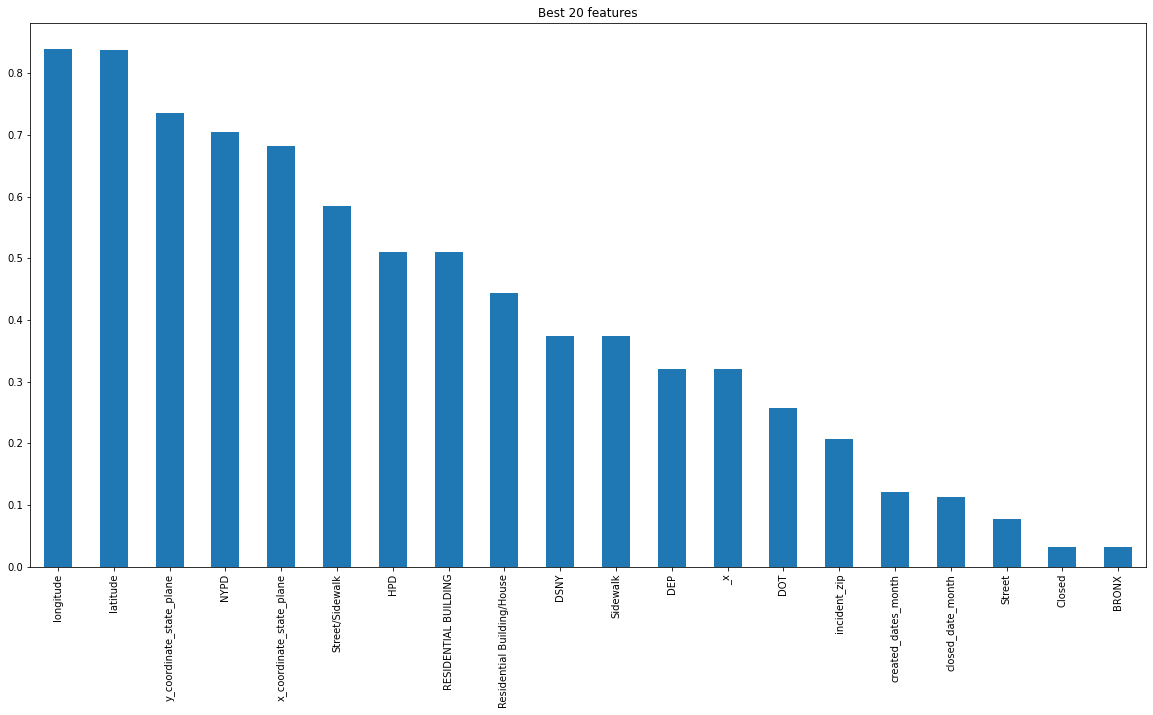

In [18]:
num_components= 20
components = mutual_info.sort_values(ascending=False).nlargest(num_components).keys().tolist()
mutual_info.sort_values(ascending=False).nlargest(num_components).plot(kind="bar", figsize=(20,10))
plt.title(f"Best {num_components} features")

In [19]:

X_train_feature_selected = X_train[[c for c in X_train.columns if c in components]]
X_test_feature_selected = X_test[[c for c in X_test.columns if c in components]]
del X_train
del X_test

# **Predicting COMPLAINT TYPE given selected features**

In [20]:
 #Decision tree classifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train_feature_selected,y_train)
y_pred_dt=dt_clf.predict(X_test_feature_selected)
print("Accuracy Score: ",accuracy_score(y_test,y_pred_dt))
print(classification_report(y_test,y_pred_dt))
print("ROC_AUC: ",roc_auc_score(y_test, dt_clf.predict_proba(X_test_feature_selected), multi_class='ovr'))


Accuracy Score:  0.8742406799588498
                                     precision    recall  f1-score   support

                   Blocked Driveway       0.71      0.72      0.71     16848
                     HEAT/HOT WATER       0.91      0.93      0.92     25096
                    Illegal Parking       0.77      0.77      0.77     24055
                              Noise       0.82      0.82      0.82      7361
                Noise - Residential       0.99      0.99      0.99     28843
            Noise - Street/Sidewalk       0.78      0.77      0.78     12751
Request Large Bulky Item Collection       1.00      1.00      1.00     19905
                   Street Condition       1.00      1.00      1.00     11630
               UNSANITARY CONDITION       0.76      0.70      0.73      8238
                       Water System       0.85      0.85      0.85      8577

                           accuracy                           0.87    163304
                          macro avg   

In [22]:
x_tr,y_tr= np.array(X_train_feature_selected), np.array(y_train)
x_ts, y_tst = np.array(X_test_feature_selected), np.array(y_test)


In [26]:

#Random Forest Classifier
rnd_clf= RandomForestClassifier(n_estimators= 500, n_jobs= -1)
rnd_clf.fit(X_train_feature_selected, y_train)
y_pred_rf = rnd_clf.predict(X_test_feature_selected)
print("Accuracy Score: ",accuracy_score(y_test,y_pred_rf))
print(classification_report(y_test,y_pred_rf))
print("ROC_AUC: ",roc_auc_score(y_test, rnd_clf.predict_proba(X_test_feature_selected), multi_class='ovr'))


Accuracy Score:  0.8808663596727575
                                     precision    recall  f1-score   support

                   Blocked Driveway       0.72      0.71      0.71     16848
                     HEAT/HOT WATER       0.91      0.93      0.92     25096
                    Illegal Parking       0.77      0.78      0.78     24055
                              Noise       0.85      0.83      0.84      7361
                Noise - Residential       0.99      0.99      0.99     28843
            Noise - Street/Sidewalk       0.81      0.78      0.79     12751
Request Large Bulky Item Collection       1.00      1.00      1.00     19905
                   Street Condition       1.00      1.00      1.00     11630
               UNSANITARY CONDITION       0.78      0.73      0.75      8238
                       Water System       0.86      0.87      0.87      8577

                           accuracy                           0.88    163304
                          macro avg   

In [30]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
mlp_clf= MLPClassifier(random_state=1, max_iter=100).fit(np.array(X_train_feature_selected),y_train)
y_pred_mlp= mlp_clf.predict(np.array(X_test_feature_selected))
print("Accuracy Score: ",accuracy_score(y_test,y_pred_mlp))
print(classification_report(y_test,y_pred_mlp))
print("ROC_AUC: ",roc_auc_score(y_test, mlp_clf.predict_proba(X_test_feature_selected), multi_class='ovr'))

Accuracy Score:  0.1766215157007789


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWar

                                     precision    recall  f1-score   support

                   Blocked Driveway       0.00      0.00      0.00     16848
                     HEAT/HOT WATER       0.00      0.00      0.00     25096
                    Illegal Parking       0.00      0.00      0.00     24055
                              Noise       0.00      0.00      0.00      7361
                Noise - Residential       0.18      1.00      0.30     28843
            Noise - Street/Sidewalk       0.00      0.00      0.00     12751
Request Large Bulky Item Collection       0.00      0.00      0.00     19905
                   Street Condition       0.00      0.00      0.00     11630
               UNSANITARY CONDITION       0.00      0.00      0.00      8238
                       Water System       0.00      0.00      0.00      8577

                           accuracy                           0.18    163304
                          macro avg       0.02      0.10      0.03    1633

In [ ]:
X_test_feature_selected.shape

**Conclusion**

* Overall Random-Forest provides a better Precision and Recall.
* Unable to complete the entire data product due to time shortage.
*   Typically I would visualize the performance of all the models in terms to each other and make a pipeline. I would also make an API and expose the classifier to an endpoint to predict data sent in the payload of http post requests and return the classified label. There would also be a pydantic model present in the post request to validate the json data and do preprocessing.  

